<a href="https://colab.research.google.com/github/Bibhash123/Estimation-of-Surface-NO2/blob/main/Results%20and%20Analysis/Validation_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import files
_ = files.upload()
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bibhash123/ireland2021
!unzip ireland2021.zip -d "/content/dataset"
!rm ireland2021.zip
from IPython.display import clear_output
clear_output(wait=False)

In [2]:
!pip uninstall -y shapely
!pip uninstall -y cartopy
!pip install shapely cartopy --no-binary shapely --no-binary cartopy
clear_output(wait=False)

In [7]:
import numpy as np
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import utils
import gc

SEED=123
def seedAll(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"]=str(seed)

seedAll(SEED)

# EXP 1: RMSE Score vs Number of Layers

In [4]:
files = pd.read_csv("/content/dataset/files.csv").sample(frac=1).reset_index(drop=True)

In [5]:
def loadData(df,satdir = "/content/dataset/satellite/",gdir = "/content/dataset/ground/"):
  X = []
  Y = []
  for i in range(df.shape[0]):
    factor = 46*(6.02214/6.023)*1e2
    sat = np.expand_dims(factor*np.load(os.path.join(satdir,df["SatFile"].iloc[i])),axis=2)      
    ground = np.load(os.path.join(gdir,df["GroundFile"].iloc[i])).flatten()
    if not np.isnan(np.sum(sat)) and not np.isnan(np.sum(ground)):
      if not np.std(ground)==0:
        X.append(sat)
        Y.append(ground)
  return np.stack(X,axis=0),np.stack(Y,axis=0)

In [6]:
def build_model(X_train,num_layers_16=1):
  inp = L.Input(shape=X_train[0].shape)
  if num_layers_16>=1:
    h = L.Conv2D(16,(3,3),activation="linear",padding="same")(inp)
    for _ in range(num_layers_16-1):
      h = L.Conv2D(16,(3,3),activation="linear")(h)
    h = L.Conv2D(32,(3,3),activation="linear")(h)
  else:
    h = L.Conv2D(32,(3,3),activation="linear")(inp)
  out = L.Flatten()(h)
  out = L.Dense(100,activation="linear")(out)
  out = L.Dense(np.prod(X_train[0].shape),activation="linear")(out)
  model = Model(inputs=inp,outputs=out)
  model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",
                metrics=[RootMeanSquaredError()])
  
  return model

In [8]:
CV_rmses = []
n_trials = 8

for i in range(n_trials):
  rmses = []
  print("\nTraining with {} 16 filter layers\n".format(i))

  for fold in range(5):
    train_files = files[files["Fold"]!=fold]
    val_files = files[files["Fold"]==fold]

    X_train,Y_train = loadData(train_files)
    X_val,Y_val = loadData(val_files)
    # loss_plt = utils.loss_plt()
    K.clear_session()
    model = build_model(X_train,num_layers_16 = i)
    if fold==0:
      print(model.summary())
    ckpt = ModelCheckpoint(f"model_{fold}.hdf5",monitor="val_root_mean_squared_error",mode="min",save_best_only=True,save_weights_only=True)
    model.fit(X_train,Y_train,
              epochs=50,
              verbose=0,
              batch_size=8,
              validation_data = (X_val,Y_val),
              callbacks=[ckpt])
    model.load_weights(f"model_{fold}.hdf5")
    rmse = mean_squared_error(Y_val,model.predict(X_val),squared=False)
    rmses.append(rmse)
    print("Fold {} RMSE Score: {}".format(fold, rmse))
    del model
    _=gc.collect()
  CV_rmses.append(np.mean(rmses))
  print("\nCV RMSE Score with {} 16 filter layers: {}".format(i, np.mean(rmses)))


Training with 0 16 filter layers

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49, 67, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 65, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 97760)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               9776100   
_________________________________________________________________
dense_1 (Dense)              (None, 3283)              331583    
Total params: 10,108,003
Trainable params: 10,108,003
Non-trainable params: 0
_________________________________________________________________
None
Fold 0 RMSE Score: 6.754436538080747
Fold 1 RMSE Score: 8.132806528959087
F

### Exp 1.2 : With Max Pooling

In [9]:
def build_model(X_train,num_layers_16=1):
  inp = L.Input(shape=X_train[0].shape)
  if num_layers_16>=1:
    h = L.Conv2D(16,(3,3),activation="linear",padding="same")(inp)
    for j in range(num_layers_16-1):
      h = L.Conv2D(16,(3,3),activation="linear")(h)
      if j%3==0:
        h = L.MaxPooling2D(pool_size=(2,2),strides=2)(h)

    h = L.Conv2D(32,(3,3),activation="linear")(h)
  else:
    h = L.Conv2D(32,(3,3),activation="linear")(inp)
  out = L.Flatten()(h)
  out = L.Dense(100,activation="linear")(out)
  out = L.Dense(np.prod(X_train[0].shape),activation="linear")(out)
  model = Model(inputs=inp,outputs=out)
  model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",
                metrics=[RootMeanSquaredError()])
  
  return model

In [10]:
CV_rmses_with = []
n_trials = 8

for i in range(n_trials):
  rmses = []
  print("\nTraining with {} 16 filter layers\n".format(i))

  for fold in range(5):
    train_files = files[files["Fold"]!=fold]
    val_files = files[files["Fold"]==fold]

    X_train,Y_train = loadData(train_files)
    X_val,Y_val = loadData(val_files)
    # loss_plt = utils.loss_plt()
    K.clear_session()
    model = build_model(X_train,num_layers_16 = i)
    if fold==0:
      print(model.summary())
    ckpt = ModelCheckpoint(f"model_{fold}.hdf5",monitor="val_root_mean_squared_error",mode="min",save_best_only=True,save_weights_only=True)
    model.fit(X_train,Y_train,
              epochs=50,
              verbose=0,
              batch_size=8,
              validation_data = (X_val,Y_val),
              callbacks=[ckpt])
    model.load_weights(f"model_{fold}.hdf5")
    rmse = mean_squared_error(Y_val,model.predict(X_val),squared=False)
    rmses.append(rmse)
    print("Fold {} RMSE Score: {}".format(fold, rmse))
    del model
    _=gc.collect()
  CV_rmses_with.append(np.mean(rmses))
  print("\nCV RMSE Score with {} 16 filter layers: {}".format(i, np.mean(rmses)))


Training with 0 16 filter layers

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49, 67, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 47, 65, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 97760)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               9776100   
_________________________________________________________________
dense_1 (Dense)              (None, 3283)              331583    
Total params: 10,108,003
Trainable params: 10,108,003
Non-trainable params: 0
_________________________________________________________________
None
Fold 0 RMSE Score: 6.764757630274225
Fold 1 RMSE Score: 8.175115511396056
F

In [11]:
df = pd.DataFrame(columns=["n_16_layers","CV RMSE","maxpool"])
df.loc[:,'n_16_layers'] = list(range(n_trials))+list(range(n_trials))
df.loc[:,'CV RMSE'] = CV_rmses+CV_rmses_with
df.loc[:,"maxpool"] = [False for _ in range(n_trials)]+[True for _ in range(n_trials)]

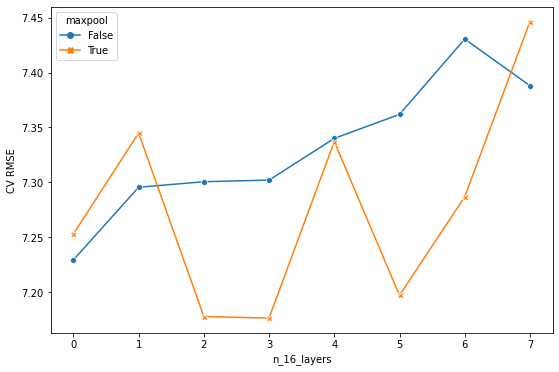

In [12]:
plt.figure(figsize=(9,6))
sns.lineplot(data = df, x = "n_16_layers", y = 'CV RMSE',hue='maxpool',
             style="maxpool", markers=True, dashes=False)